# <center style="color: #000000ff;"> **Общая информация** </center>

В рамках [нашего проекта](https://github.com/alinaavanesyan/interactive-llm-game) в качестве данных было решено взять сценарий сериала "Конь БоДжек" (BoJack Horseman). [Ссылка на данные](https://genius.com/Bojack-horseman-bojack-horseman-the-bojack-horseman-story-chapter-one-script-annotated).

**Почему сценарий и почему сценарий?**
1. Во-первых, нам важно наличие в датасете информации по нескольким героям, т.к. для наша визуальная новелла подразумевает выбор героя, за которого пользователь решает начать играть.
2. Во-вторых, для формирования диалогов между главным героем и побочными необходимо иметь представление, какова рода установлены отношения между ними. Мы планируем реализовать некую RAG-систему, которая при формировании ответа в ответ на реплику пользователя будет опираться на:
- краткое описание сюжета
- характеристику героя
- прошлые диалоги героя с персонажем, с которым ведется беседа (если они были)

# <center style="color: #000000ff;"> **Импорт библиотек и установка зависимостей** </center>

In [ ]:
import re
import os
from collections import defaultdict
import tiktoken

import chromadb
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from tqdm import tqdm
from transformers import pipeline
from sentence_transformers import SentenceTransformer

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as n
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

import numpy as np
from collections import defaultdict

/Users/mac/Documents/Seminars/menv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install chromadb tiktoken sentence-transformers bertopic matplotlib wordcloud nltk

In [ ]:
!pip install nbformat --upgrade

In [ ]:
!!pip install -U nbformat

In [ ]:
!pip install -U "hdbscan>=0.8.28"

# <center style="color: #000000ff;"> **Парсинг данных** </center>

In [ ]:
SCRIPT_PATH = "script.txt"
CHROMA_PATH = "./chroma_store"
COLLECTION_NAME = "bojack_script"

CHUNK_SIZE = 400
CHUNK_OVERLAP = 50
MODEL_NAME = "all-MiniLM-L6-v2"
enc = tiktoken.get_encoding("cl100k_base")


embedder = SentenceTransformer(MODEL_NAME)

client = chromadb.PersistentClient(path=CHROMA_PATH)
collection = client.get_or_create_collection(name=COLLECTION_NAME)

def read_script(path: str) -> str:
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

def count_tokens(text: str) -> int:
    return len(enc.encode(text))

def chunk_text(text: str, chunk_size=400, overlap=50):
    tokens = enc.encode(text)
    chunks = []
    i = 0
    while i < len(tokens):
        j = min(i + chunk_size, len(tokens))
        chunk = enc.decode(tokens[i:j])
        chunks.append(chunk)
        i += chunk_size - overlap
    return chunks


def extract_role(line: str):
    m = re.match(r"^([A-Z][A-Z\s'\-]+):", line.strip())
    return m.group(1).strip() if m else None

text = read_script(SCRIPT_PATH)

paragraphs = [p.strip() for p in text.split("\n") if p.strip()]

documents = []
metadatas = []
ids = []

chunk_id = 0

for i, para in enumerate(paragraphs):
    role = extract_role(para)
    chunks = chunk_text(para, CHUNK_SIZE, CHUNK_OVERLAP)
    for j, ch in enumerate(chunks):
        tok = count_tokens(ch)
        documents.append(ch)
        metadatas.append({
            "role": role or "UNKNOWN",
            "source_para": i,
            "chunk": j,
            "tokens": tok
        })
        ids.append(f"chunk-{chunk_id}")
        chunk_id += 1

embeddings = embedder.encode(documents, show_progress_bar=True).tolist()

collection.add(documents=documents, embeddings=embeddings, metadatas=metadatas, ids=ids)

In [ ]:
!zip -r chroma_store.zip chroma_store
from google.colab import files
files.download("chroma_store.zip")

  adding: chroma_store/ (stored 0%)
  adding: chroma_store/36f71b6c-5104-459b-a417-cb69a7f92d08/ (stored 0%)
  adding: chroma_store/36f71b6c-5104-459b-a417-cb69a7f92d08/link_lists.bin (stored 0%)
  adding: chroma_store/36f71b6c-5104-459b-a417-cb69a7f92d08/header.bin (deflated 63%)
  adding: chroma_store/36f71b6c-5104-459b-a417-cb69a7f92d08/data_level0.bin (deflated 100%)
  adding: chroma_store/36f71b6c-5104-459b-a417-cb69a7f92d08/length.bin (deflated 87%)
  adding: chroma_store/chroma.sqlite3 (deflated 41%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
client = chromadb.PersistentClient(path="./chroma_store")
collection = client.get_collection("bojack_script")

query = "Bojack is a total jerk"
res = collection.query(query_texts=[query], n_results=3)
for doc, meta in zip(res["documents"][0], res["metadatas"][0]):
    print(meta["role"], "→", doc[:150], "...\n")

/Users/mac/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:07<00:00, 11.3MiB/s]


BOJACK → BOJACK: What? ...

BOJACK → BOJACK: What? ...

UNKNOWN → BOJACK He's so stupid he doesn't realize how miserable he should be. I envy that. ...



# <center style="color: #000000ff;"> **Анализ** </center>

In [23]:
# Подключаемся к уже существующей базе
client = chromadb.PersistentClient(path="./chroma_store")

collection = client.get_collection(name="bojack_script")
results = collection.peek()

print(collection.count())

471


In [24]:
results

{'ids': ['chunk-0',
  'chunk-1',
  'chunk-2',
  'chunk-3',
  'chunk-4',
  'chunk-5',
  'chunk-6',
  'chunk-7',
  'chunk-8',
  'chunk-9'],
 'embeddings': array([[-0.0852196 ,  0.0445068 ,  0.03287771, ...,  0.04426251,
         -0.01574427, -0.07887249],
        [-0.10503181, -0.03684993, -0.00955197, ...,  0.01481338,
          0.04673866, -0.0050662 ],
        [-0.03311339,  0.02496204, -0.02989882, ...,  0.03135622,
          0.01595793,  0.09053562],
        ...,
        [-0.01893458,  0.04767914,  0.0242776 , ...,  0.0362582 ,
          0.00486688,  0.02266341],
        [-0.01843998, -0.02441525, -0.02591411, ...,  0.00263808,
          0.06623096,  0.01641465],
        [-0.01983688, -0.00026752,  0.08641001, ...,  0.01011902,
         -0.06613155, -0.02514374]], shape=(10, 384)),
 'documents': ['BoJack Horseman: The BoJack Horseman Story, Chapter One (Script) Lyrics',
  'Bojack Horseman is a surreal comedy about a washed up horse-man actor. It also has incredibly cool intro music:

In [4]:
# пример чанка
collection.get(ids=["chunk-0"])

{'ids': ['chunk-0'],
 'embeddings': None,
 'documents': ['BoJack Horseman: The BoJack Horseman Story, Chapter One (Script) Lyrics'],
 'uris': None,
 'included': ['metadatas', 'documents'],
 'data': None,
 'metadatas': [{'role': 'UNKNOWN',
   'source_para': 0,
   'chunk': 0,
   'tokens': 18}]}

In [25]:
all_data = collection.get()
list_of_documents = all_data['documents']

list_of_documents[:5]

['BoJack Horseman: The BoJack Horseman Story, Chapter One (Script) Lyrics',
 'Bojack Horseman is a surreal comedy about a washed up horse-man actor. It also has incredibly cool intro music:',
 "V/O: Horsin' Around is filmed before a live studio audience.",
 "ENT: Kitchen of an 80's furnished house",
 'Bojack is in a loud orange sweatshirt doing dishes and']

## <p style="color: #007bff;"> 1.1. Уникальные роли </p>

In [26]:
data = collection.get(include=["documents", "metadatas"])
docs = data["documents"]
metas = data["metadatas"]

df = pd.DataFrame([
    {"text": d, "role": m.get("role", "UNKNOWN"), "tokens": m.get("tokens", 0)}
    for d, m in zip(docs, metas)
])

df.head()

,text,role,tokens
0,"BoJack Horseman: The BoJack Horseman Story, Ch...",UNKNOWN,18
1,Bojack Horseman is a surreal comedy about a wa...,UNKNOWN,24
2,V/O: Horsin' Around is filmed before a live st...,UNKNOWN,16
3,ENT: Kitchen of an 80's furnished house,ENT,10
4,Bojack is in a loud orange sweatshirt doing di...,UNKNOWN,12


In [27]:
df['role'].unique()

array(['UNKNOWN', 'ENT', 'SABRINA', 'BOJACK', 'CHARLIE ROSE', 'MAURY',
       'TODD', 'TOD', 'PINKY', 'WAITRESS', 'BOJACK ON TV', 'SARAH',
       'BOJAC', 'CAROLYN', 'TURTLETAUB', 'GIRL', 'COP', 'WAITER',
       'STRANGER', 'OPERATOR', 'SARAH LYNN', 'MOB BOSS', 'DOCTOR',
       'CAROYLN', 'PIG DOCTOR', 'DIANE', 'BOTH'], dtype=object)

In [28]:
print("Размер:", len(df))
print("Количество ролей:", df["role"].nunique())
print(df["role"].value_counts().head())

Размер: 471
Количество ролей: 27
role
BOJACK     153
UNKNOWN    135
CAROLYN     40
TODD        38
DIANE       26
Name: count, dtype: int64


Среди ролей видим слишком похожие роли,проверим, не является ли это опечаткой.

**1. Роли TOD и TODD**

In [15]:
print(df[df["role"] == "TOD"].shape)
df[df["role"] == "TOD"].iloc[0].text

(1, 3)


"TOD: That's on you for making assumptions. Also, if you're looking for the Toaster Strudels, I got really high last night and ate them all."

Поскольку большинство реплик героя приписано роли TODD, а у TOD одна реплика, явно принадлежащая герою (см. выше), то исправим опечатку:

In [22]:
df.loc[df["role"] == "TOD", "role"] = "TODD"
print(df[df["role"] == "TOD"].shape)

(0, 3)


**2. Роли BOJACK, BOJAC и BOJACK ON TV**

In [ ]:
df[df["role"] == "BOJACK ON TV"]

,text,role,tokens
93,BOJACK ON TV: You're wearing that to the prom?,BOJACK ON TV,14
95,"BOJACK ON TV: Neigh way, Jose.",BOJACK ON TV,12
128,"BOJACK ON TV: Now, that's a horse of a differe...",BOJACK ON TV,16
267,"BOJACK ON TV: I know kindergarten is scary, bu...",BOJACK ON TV,27
269,"BOJACK ON TV: Wait, did you just call me ""Daddy""?",BOJACK ON TV,17


Поскольку роль BOJACK ON TV не отражает реального характера героя, т.к. является прописанным сценария для героя фильма, которого играет BOJACK, то роль BOJACK ON TV нам не представляется интересной, не конкатенируем её с BOJACK.

In [10]:
df[df["role"] == "BOJAC"]

,text,role,tokens
105,BOJAC: [belches],BOJAC,8


Роль BOJAC неинформативна, поэтому пропускаем её.

**Роль ENT** - enter - разделитель сцен. Разделим наш текст на сцены:

In [50]:
def split_by_scenes(paragraphs):
    scenes = []
    current_scene = []
    for p in paragraphs:
        if p.startswith("ENT:"):
            if current_scene:
                scenes.append(current_scene)
            current_scene = [p]
        else:
            current_scene.append(p)
    if current_scene:
        scenes.append(current_scene)
    return scenes

scenes = split_by_scenes([d for d in collection.get()["documents"]])

In [33]:
scenes[:2]

[['BoJack Horseman: The BoJack Horseman Story, Chapter One (Script) Lyrics',
  'Bojack Horseman is a surreal comedy about a washed up horse-man actor. It also has incredibly cool intro music:',
  "V/O: Horsin' Around is filmed before a live studio audience."],
 ["ENT: Kitchen of an 80's furnished house",
  'Bojack is in a loud orange sweatshirt doing dishes and',
  'young Sarah plops down at the table in a bad mood',
  'SABRINA: [sighs] Mondays.',
  'BOJACK: [laughs] Well, good morning to you too.',
  'SABRINA: Oh, hey.',
  'BoJack drops his plate and looks around for some hay; Sarah giggles',
  "BOJACK: Where? I'd love hay."]]

Создадим словарь: кто с кем говорил и что сказал.

In [ ]:
def extract_dialogues(scenes):
    dialogues = defaultdict(list)
    for scene in scenes:
        roles_in_scene = set()
        for line in scene:
            match = re.match(r"^([A-Z][A-Z\s'\-]+):", line)
            if match:
                role = match.group(1).strip()
                roles_in_scene.add(role)
        for role in roles_in_scene:
            dialogues[role].append({
                "scene_roles": list(roles_in_scene),
                "scene_text": " ".join(scene)
            })
    return dialogues

dialogues = extract_dialogues(scenes)
print(dialogues["BOJACK"][0]["scene_roles"])  # С кем Боджек был в первой совместной сцене

['SABRINA', 'BOJACK', 'ENT']


In [36]:
dialogues

defaultdict(list,
            {'SABRINA': [{'scene_roles': ['SABRINA', 'BOJACK', 'ENT'],
               'scene_text': "ENT: Kitchen of an 80's furnished house Bojack is in a loud orange sweatshirt doing dishes and young Sarah plops down at the table in a bad mood SABRINA: [sighs] Mondays. BOJACK: [laughs] Well, good morning to you too. SABRINA: Oh, hey. BoJack drops his plate and looks around for some hay; Sarah giggles BOJACK: Where? I'd love hay."},
              {'scene_roles': ['DOCTOR', 'BOJACK', 'SABRINA', 'ENT'],
               'scene_text': "ENT: Hospital on a t.v. screen DOCTOR: [monitor beeping] [steady tone] [groans] [sighs] Well, we did everything we could. Nurse, record the time of death. It doesn't get easier. It never gets easier. SABRINA: [both sigh] [Sabrina crying] What I don't What do you mean he's dead? DOCTOR: That's right, sweetheart. He died of a broken heart because you didn't appreciate him enough, and now he's gone forever. BOJACK: We might have gone too dark 

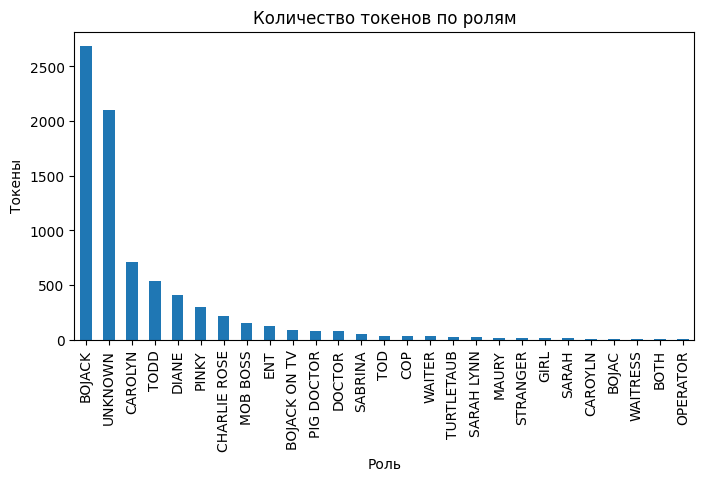

In [38]:
role_stats = (
    df.groupby("role")
    .agg(replicas=("text", "count"), tokens=("tokens", "sum"))
    .sort_values("tokens", ascending=False)
)

plt.figure(figsize=(8,4))
role_stats["tokens"].plot(kind="bar", title="Количество токенов по ролям")
plt.ylabel("Токены")
plt.xlabel("Роль")
plt.show()

Теперь посмотрим на тематическое содержание разговоров. Для этого найдем наиболее частотные слова и сделаем из них облако слов, а также посчитаем статистику по часто встречающимся биграммам и триграммам.

Сперва удалим стоп-слова, чтобы они не создали шум в данных:

In [44]:
stop_en = set(stopwords.words("english"))
extra_stops = {
    "yeah","yeahh","yea","uh","oh","ha","haah","huh","hey","gonna","wanna",
    "gotta","okay","ok","right","like","really","well","just","bojack",
    "todd","diane","carolyn","princess","pinky","sarah","sarahlynn","mr",
    "peanutbutter","ent"
}
STOPWORDS = stop_en.union(extra_stops)

def clean_dialogue_remove_stopwords(text):
    # Убираем метки ролей
    text = re.sub(r"\b[A-Z][A-Z\s'\-]+\b:", " ", text)
    # Убираем ENT
    text = re.sub(r"\bENT[: ]", " ", text)
    # Убираем содержимое в квадратных/круглых скобках (саунд-эффекты, эмоции)
    text = re.sub(r"\[.*?\]|\(.*?\)", " ", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text).lower()
    tokens = [t for t in text.split() if len(t) > 2 and t not in STOPWORDS]
    return " ".join(tokens)
    
df["text_cleaned"] = df["text"].apply(clean_dialogue_remove_stopwords)

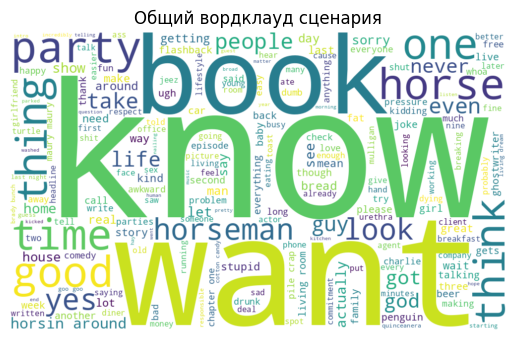

In [45]:
all_text = " ".join(df["text_cleaned"])
wc = WordCloud(width=1000, height=600, background_color="white").generate(all_text)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Общий вордклауд сценария")
plt.show()

In [48]:
vectorizer = CountVectorizer(
    ngram_range=(2,3),
    stop_words="english",
    min_df=2,
    max_features=1000
)

X = vectorizer.fit_transform(df["text"])
sum_words = X.sum(axis=0)
freq = [(word, int(sum_words[0, idx])) for word, idx in vectorizer.vocabulary_.items()]
freq = sorted(freq, key=lambda x: x[1], reverse=True)
print("Топ-30 би- и триграмм:")

for w, f in freq[:30]:
    print(f"{w}: {f}")

Топ-30 би- и триграмм:
mr peanutbutter: 29
bojack horseman: 11
charlie rose: 10
bojack oh: 10
bojack yeah: 9
oh god: 7
don want: 5
bojack yes: 5
ent bojack: 5
bojack living: 5
living room: 5
ent bojack living: 5
bojack living room: 5
bojack tv: 5
todd oh: 5
mob boss: 5
pig doctor: 5
don think: 4
bojack just: 4
bojack know: 4
bojack ugh: 4
carolyn bojack: 4
bojack hey: 4
carolyn oh: 4
peanutbutter bojack: 4
mr peanutbutter bojack: 4
pile crap: 4
did say: 3
want know: 3
bojack told: 3


In [15]:
query = "Bojack talks about depression"
results = collection.query(
    query_texts=[query],
    n_results=3
)

for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
    print(meta["role"], ":", doc[:100], "...")


BOJACK : BOJACK: Good Lord, that's depressing. ...
BOJACK : BOJACK: What? ...
BOJACK : BOJACK: What? ...


Разложим по тематикам контексты каждого из четырех главных героев, за которых пользователь сможет в будущем играть. Для этого предварительно инициалиризуем эти функции:

In [ ]:
model_name = "Qwen/Qwen3-Embedding-0.6B" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")

def get_qwen_embeddings(texts):
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state.mean(dim=1)
    
    embeddings = embeddings.to(torch.float32).cpu().numpy()
    return embeddings

def qwen_embedder_batch(texts, batch_size=8):
    all_embs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        chunk = texts[i:i+batch_size]
        emb = get_qwen_embeddings(chunk)
        all_embs.append(emb)
    return np.vstack(all_embs)2

stops = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    text = " ".join([w for w in text.split() if w not in stops])
    return text

texts = ["BoJack is sad", "Diane is smart"]
embeds = get_qwen_embeddings(texts)
print(embeds.shape)

`torch_dtype` is deprecated! Use `dtype` instead!


(2, 1024)


## <p style="color: #007bff;"> 1.2. Анализ основных героев </p>

В результате анализа частотности реплик выделяется четыре основных героя: BOJACK, CAROLYN, TODD, DIANE. Именно за этих героев можно будет поиграть в нашей новелле.

! показать связи

### **Bojack**

In [54]:
raw_bojack_scenes = [d["scene_text"] for d in dialogues["BOJACK"]]
cleaned_bojack = [clean_dialogue_remove_stopwords(s) for s in raw_bojack_scenes]
cleaned_bojack_phrases = df[df["role"] == 'BOJACK']["text_cleaned"]

In [52]:
dialogues

defaultdict(list,
            {'SABRINA': [{'scene_roles': ['SABRINA', 'BOJACK', 'ENT'],
               'scene_text': "ENT: Kitchen of an 80's furnished house Bojack is in a loud orange sweatshirt doing dishes and young Sarah plops down at the table in a bad mood SABRINA: [sighs] Mondays. BOJACK: [laughs] Well, good morning to you too. SABRINA: Oh, hey. BoJack drops his plate and looks around for some hay; Sarah giggles BOJACK: Where? I'd love hay."},
              {'scene_roles': ['DOCTOR', 'BOJACK', 'SABRINA', 'ENT'],
               'scene_text': "ENT: Hospital on a t.v. screen DOCTOR: [monitor beeping] [steady tone] [groans] [sighs] Well, we did everything we could. Nurse, record the time of death. It doesn't get easier. It never gets easier. SABRINA: [both sigh] [Sabrina crying] What I don't What do you mean he's dead? DOCTOR: That's right, sweetheart. He died of a broken heart because you didn't appreciate him enough, and now he's gone forever. BOJACK: We might have gone too dark 

In [20]:
raw_bojack_scenes

["ENT: Kitchen of an 80's furnished house Bojack is in a loud orange sweatshirt doing dishes and young Sarah plops down at the table in a bad mood SABRINA: [sighs] Mondays. BOJACK: [laughs] Well, good morning to you too. SABRINA: Oh, hey. BoJack drops his plate and looks around for some hay; Sarah giggles BOJACK: Where? I'd love hay.",
 'ENT: Charlie Rose interviewing BoJack CHARLIE ROSE:  In 1987, the situation comedy Horsin\' Around premiered on ABC. BoJack is shown sharing a giant bowl of ice cream with a happy family; in another picture he is eating it all to himself and the family is sad CHARLIE ROSE: The show, in which a young, bachelor horse is forced to reevaluate his priorities when he agrees to raise three human children, was initially dismissed by critics as broad and saccharine and not good, but the family comedy struck a chord with America and went on to air for nine seasons. The star of Horsin\' Around, BoJack Horseman, is our guest tonight. Welcome, BoJack. BOJACK: It is

#### Темы разговоров BOJACK

In [67]:
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric="euclidean",
    cluster_selection_method='eom',
    prediction_data=True
)

In [ ]:
topic_model = BERTopic(
    embedding_model=lambda texts: qwen_embedder_batch(texts, batch_size=8),
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(cleaned_bojack)
topic_info = topic_model.get_topic_info()

2025-10-26 19:27:55,620 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
2025-10-26 19:28:09,827 - BERTopic - Embedding - Completed ✓
2025-10-26 19:28:09,828 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-26 19:28:22,091 - BERTopic - Dimensionality - Completed ✓
2025-10-26 19:28:22,092 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-26 19:28:22,125 - BERTopic - Cluster - Completed ✓
2025-10-26 19:28:22,141 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-26 19:28:22,171 - BERTopic - Representation - Completed ✓


In [17]:
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,0,4,0_bread_see_think_please,"[bread, see, think, please, commitment, breaki...",[driving home car seen naked think getting chu...
1,1,4,1_book_take_party_want,"[book, take, party, want, easy, goo, stupid, s...",[living room parties fun book important want h...
2,2,3,2_know_life_good_show,"[know, life, good, show, guy, party, around, h...",[living room technically dumped real headline ...
3,3,3,3_one_chapter_office_company,"[one, chapter, office, company, penguin, week,...",[penguin penguins running around slding bellie...
4,4,3,4_baby_get_horsin_little,"[baby, get, horsin, little, neigh, jose, eyes,...",[living room watching stay home know kindergar...


In [18]:
topic_model.visualize_documents(cleaned_bojack)

In [19]:
topic_model.visualize_barchart(top_n_topics=5)

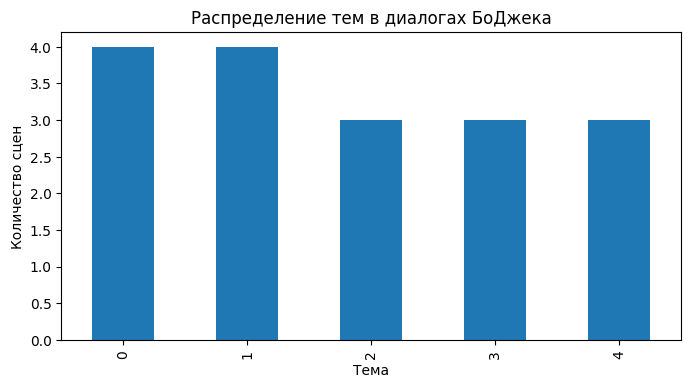

In [ ]:
topic_counts = pd.Series(topics).value_counts().sort_index()
topic_counts.plot(kind="bar", figsize=(8,4), title="Распределение тем в диалогах БоДжека")
plt.xlabel("Тема")
plt.ylabel("Количество сцен")
plt.show()

#### Эмоциональный анализ (sentiment / valence)

In [75]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

Device set to use mps:0


In [ ]:
bojack_phrases = df[df['role'] == 'BOJACK']['text']

results = []
for text in tqdm(bojack_phrases, desc="Analyzing sentiment"):
    result = sentiment_pipeline(text)
    results.append(result[0])

df_sentiment = pd.DataFrame({
    "sentence": bojack_phrases,
    "label": [r['label'] for r in results],
    "score": [r['score'] for r in results]
})

df_sentiment['label'].value_counts()

Analyzing sentiment: 100%|██████████| 153/153 [00:14<00:00, 10.54it/s]


label
NEGATIVE    109
POSITIVE     44
Name: count, dtype: int64

In [36]:
cleaned_bojack

['kitchen furnished house loud orange sweatshirt dishes young plops table bad mood mondays good morning drops plate looks around hay giggles love hay',
 'charlie rose interviewing situation comedy horsin around premiered abc shown sharing giant bowl ice cream happy family another picture eating family sad show young bachelor horse forced reevaluate priorities agrees raise three human children initially dismissed critics broad saccharine good family comedy struck chord america went air nine seasons star horsin around horseman guest tonight welcome good charlie sorry late traffic problem parked handicapped spot hope parked sorry disabled spot proper nomenclature maybe move car think drive incredibly drunk telling drunk nailing interview kind feel nailing yes anyway talking horsin around attribute show wide appeal charlie listen know know hip days shit horsin around time tell say shit please cause think show actually pretty solid ibsen sure look lot people life one long hard kick urethra 

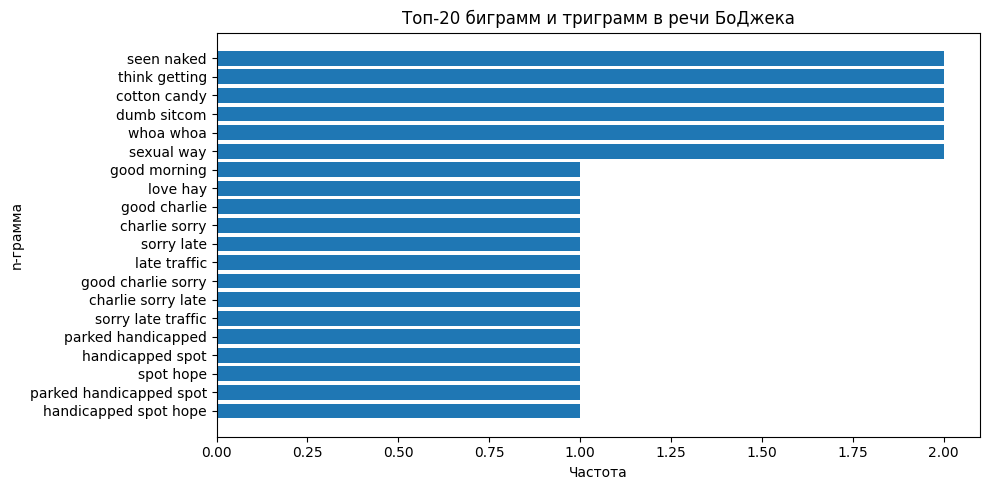

In [139]:
vectorizer = CountVectorizer(
    ngram_range=(2,3),
    stop_words="english",
    min_df=1,
    max_features=1000
)

X = vectorizer.fit_transform(cleaned_bojack_phrases)
sum_words = X.sum(axis=0)

ngrams_freq = [
    (word, int(sum_words[0, idx]))
    for word, idx in vectorizer.vocabulary_.items()
]

ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)
df_ngrams = pd.DataFrame(ngrams_freq, columns=["ngram", "freq"])

plt.figure(figsize=(10,5))
plt.barh(df_ngrams.head(20)["ngram"][::-1], df_ngrams.head(20)["freq"][::-1])
plt.title("Топ-20 биграмм и триграмм в речи БоДжека")
plt.xlabel("Частота")
plt.ylabel("n-грамма")
plt.tight_layout()
plt.show()

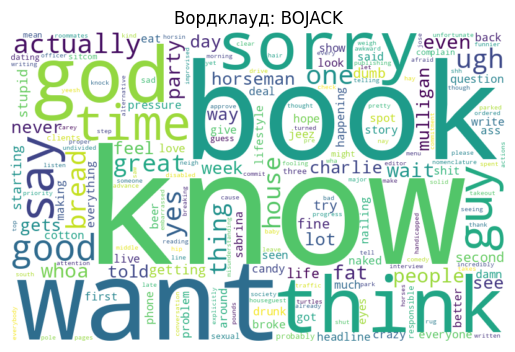

In [58]:
def make_wordcloud(role):
    subset = " ".join(df[df.role == role]["text_cleaned"])
    wc = WordCloud(width=800, height=500, background_color="white").generate(subset)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Вордклауд: {role}")
    plt.show()

make_wordcloud("BOJACK")

**Анализ по герою BOJACK**

В результате топик-моделинга выделились следующие темы:

- 0 – bread / see / think / please - тема повседневного абсурда, избегания реальности
- 1 – book / take / party / want - тема самопрезентации, попыток доказать свою значимость
- 2 - know / life / good / show - саморефлексия и кризис идентичности
- 3 – one / chapter / office / company - Тема профессиональных отношений, издательство Penguin
- 4 – baby / horsin / little / family - тема псевдоотцовства (в сериале БоДжек играет отца) и страха семьи

Топики логически разделились не по персонажам, а по сюжетным и эмоциональным линиям БоДжека.
Например, Penguin и книга (тема 3) — одна сюжетная ветка; “baby / horsin” — другая (травма от сериала и «псевдоотцовства»).

Анализ тональности показывает преобладание негативных эмоций (Боджек - самоироиничный, депрессивный герой).
Позитивные реплики чаще встречаются в контексте, когда он шутит (ирония).

### **CAROLYN**

In [81]:
raw_carolyn_scenes = [d["scene_text"] for d in dialogues["CAROLYN"]]
cleaned_carolyn = [clean_dialogue_remove_stopwords(s) for s in raw_carolyn_scenes]
cleaned_carolyn_phrases = df[df["role"] == 'CAROLYN']["text_cleaned"]

#### Темы разговоров CAROLYN

In [82]:
topic_model = BERTopic(
    embedding_model=lambda texts: qwen_embedder_batch(texts, batch_size=8),
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(cleaned_carolyn)
topic_info = topic_model.get_topic_info()

2025-10-27 20:48:40,639 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2025-10-27 20:48:52,098 - BERTopic - Embedding - Completed ✓
2025-10-27 20:48:52,099 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-27 20:48:52,176 - BERTopic - Dimensionality - Completed ✓
2025-10-27 20:48:52,178 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-27 20:48:52,213 - BERTopic - Cluster - Completed ✓
2025-10-27 20:48:52,220 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-27 20:48:52,249 - BERTopic - Representation - Completed ✓


In [83]:
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,0,5,0_bread_time_think_see,"[bread, time, think, see, know, look, baby, fa...",[fancy diner hours earlier need talk check rug...
1,1,3,1_book_want_take_party,"[book, want, take, party, easy, say, goo, stup...",[living room parties fun book important want h...


In [84]:
topic_model.visualize_documents(cleaned_carolyn)

In [85]:
topic_model.visualize_barchart(top_n_topics=5)

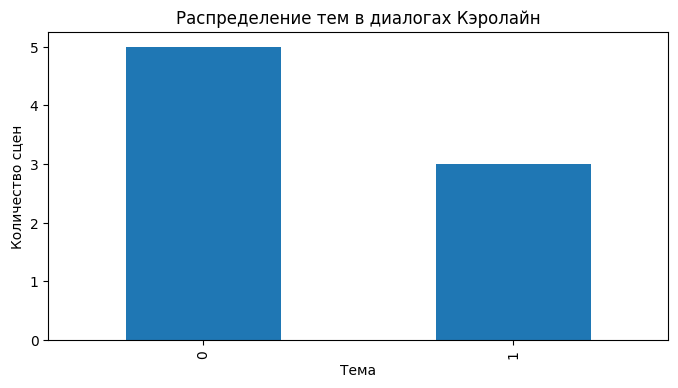

In [86]:
topic_counts = pd.Series(topics).value_counts().sort_index()
topic_counts.plot(kind="bar", figsize=(8,4), title="Распределение тем в диалогах Кэролайн")
plt.xlabel("Тема")
plt.ylabel("Количество сцен")
plt.show()

#### Эмоциональный анализ (sentiment / valence)

In [87]:
carolyn_phrases = df[df['role'] == 'CAROLYN']['text']

results = []
for text in tqdm(carolyn_phrases, desc="Analyzing sentiment"):
    result = sentiment_pipeline(text)
    results.append(result[0])

df_sentiment = pd.DataFrame({
    "sentence": carolyn_phrases,
    "label": [r['label'] for r in results],
    "score": [r['score'] for r in results]
})

df_sentiment['label'].value_counts()

Analyzing sentiment: 100%|██████████| 40/40 [00:01<00:00, 35.17it/s]


label
NEGATIVE    24
POSITIVE    16
Name: count, dtype: int64

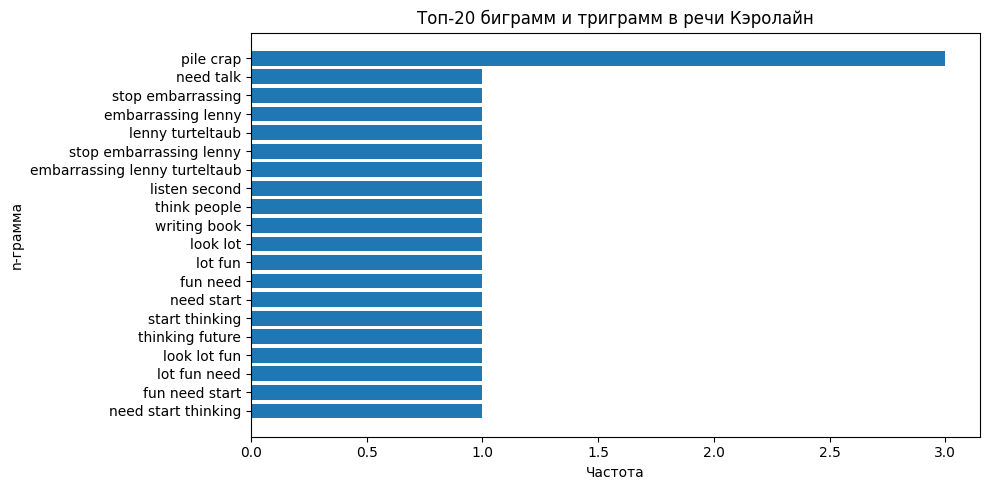

In [137]:
vectorizer = CountVectorizer(
    ngram_range=(2,3),
    stop_words="english",
    min_df=1,
    max_features=1000
)

X = vectorizer.fit_transform(cleaned_carolyn_phrases)
sum_words = X.sum(axis=0)

ngrams_freq = [
    (word, int(sum_words[0, idx]))
    for word, idx in vectorizer.vocabulary_.items()
]

ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)
df_ngrams = pd.DataFrame(ngrams_freq, columns=["ngram", "freq"])

plt.figure(figsize=(10,5))
plt.barh(df_ngrams.head(20)["ngram"][::-1], df_ngrams.head(20)["freq"][::-1])
plt.title("Топ-20 биграмм и триграмм в речи Кэролайн")
plt.xlabel("Частота")
plt.ylabel("n-грамма")
plt.tight_layout()
plt.show()

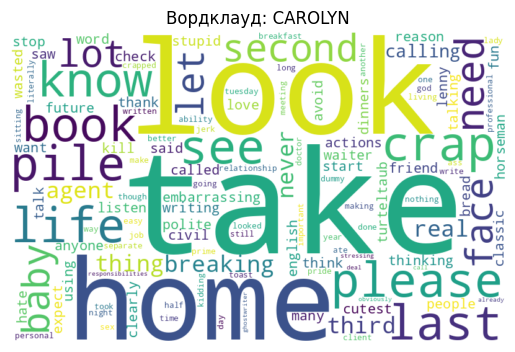

In [89]:
make_wordcloud("CAROLYN")

**Анализ по герою CAROLYN**

У Кэролайн четко прослеживается две тематики:
1. bread / time / think / see / baby / family - баланс между работой и личной жизнью
2. book / want / take / party / easy / stupid - гонка в профессии, саркастичное отношение к клиентам (Принцесса Кэролайн продюссер)

Хотя Кэролайн в целом рациональный персонаж, у неё, как и у БоДжека тоже преобладют негативные реплики, однако в меньшей доли (70% у Боджека vs 60% у Кэролайн). Возможно, это связано с рабочим стрессом.

Частые биграммы с глаголами действия (need talk, stop embarrassing, deal stressing) указывают на то, что Кэролайн - персонаж, который привык действовать (в отличие от пассивного БоДжека).

### **TODD**

In [90]:
raw_todd_scenes = [d["scene_text"] for d in dialogues["TODD"]]
cleaned_todd = [clean_dialogue_remove_stopwords(s) for s in raw_todd_scenes]
cleaned_todd_phrases = df[df["role"] == 'TODD']["text_cleaned"]

#### Темы разговоров TODD

In [95]:
topic_model = BERTopic(
    embedding_model=lambda texts: qwen_embedder_batch(texts, batch_size=8),
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(cleaned_todd)
topic_info = topic_model.get_topic_info()

2025-10-27 20:50:53,250 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
2025-10-27 20:51:04,190 - BERTopic - Embedding - Completed ✓
2025-10-27 20:51:04,191 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-27 20:51:04,277 - BERTopic - Dimensionality - Completed ✓
2025-10-27 20:51:04,278 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-27 20:51:04,304 - BERTopic - Cluster - Completed ✓
2025-10-27 20:51:04,313 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-27 20:51:04,331 - BERTopic - Representation - Completed ✓


In [96]:
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2,-1_get_sabrina_daddy_eyes,"[get, sabrina, daddy, eyes, neigh, little, jos...",[living room watching stay home know kindergar...
1,0,3,0_know_good_life_guy,"[know, good, life, guy, show, get, around, hor...",[living room technically dumped real headline ...
2,1,3,1_book_take_want_party,"[book, take, want, party, goo, easy, stupid, r...",[living room parties fun book important want h...


In [98]:
topic_model.visualize_documents(cleaned_todd)

In [99]:
topic_model.visualize_barchart(top_n_topics=5)

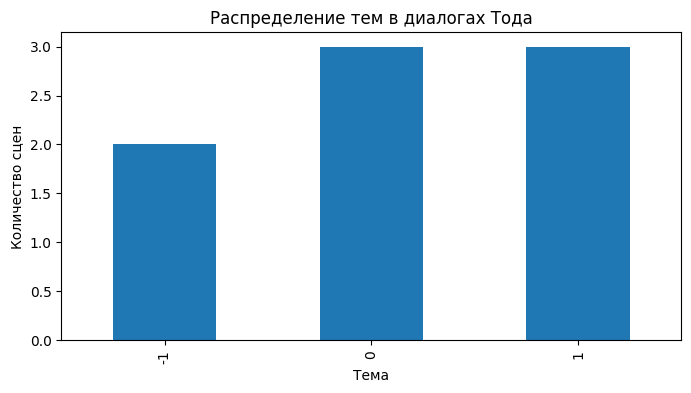

In [100]:
topic_counts = pd.Series(topics).value_counts().sort_index()
topic_counts.plot(kind="bar", figsize=(8,4), title="Распределение тем в диалогах Тода")
plt.xlabel("Тема")
plt.ylabel("Количество сцен")
plt.show()

#### Эмоциональный анализ (sentiment / valence)

In [101]:
todd_phrases = df[df['role'] == 'TODD']['text']

results = []
for text in tqdm(todd_phrases, desc="Analyzing sentiment"):
    result = sentiment_pipeline(text)
    results.append(result[0])

df_sentiment = pd.DataFrame({
    "sentence": todd_phrases,
    "label": [r['label'] for r in results],
    "score": [r['score'] for r in results]
})

df_sentiment['label'].value_counts()

Analyzing sentiment: 100%|██████████| 38/38 [00:05<00:00,  6.40it/s]


label
POSITIVE    22
NEGATIVE    16
Name: count, dtype: int64

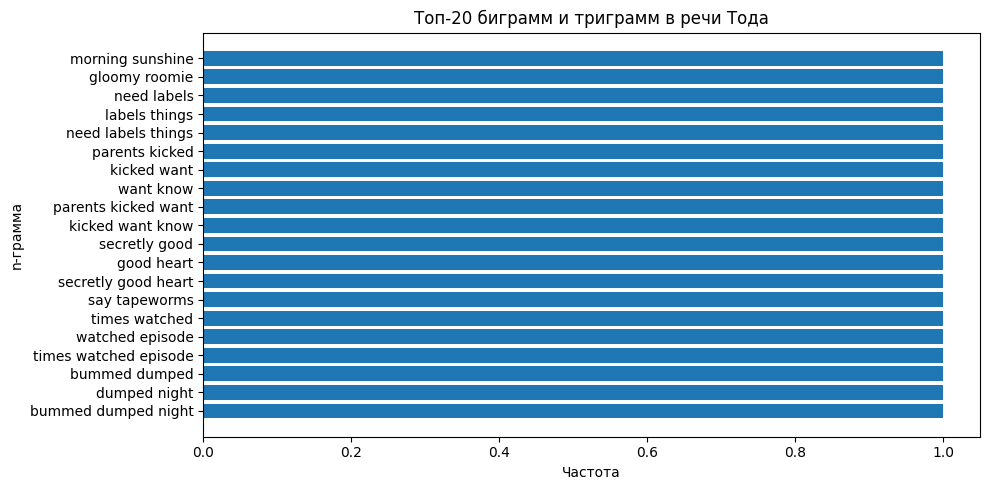

In [140]:
vectorizer = CountVectorizer(
    ngram_range=(2,3),
    stop_words="english",
    min_df=1,
    max_features=1000
)

X = vectorizer.fit_transform(cleaned_todd_phrases)
sum_words = X.sum(axis=0)

ngrams_freq = [
    (word, int(sum_words[0, idx]))
    for word, idx in vectorizer.vocabulary_.items()
]

ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)
df_ngrams = pd.DataFrame(ngrams_freq, columns=["ngram", "freq"])

plt.figure(figsize=(10,5))
plt.barh(df_ngrams.head(20)["ngram"][::-1], df_ngrams.head(20)["freq"][::-1])
plt.title("Топ-20 биграмм и триграмм в речи Тода")
plt.xlabel("Частота")
plt.ylabel("n-грамма")
plt.tight_layout()
plt.show()

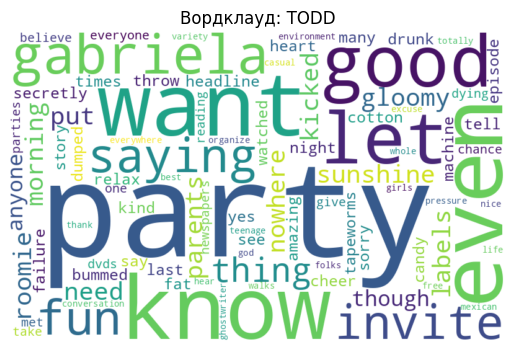

In [103]:
make_wordcloud("TODD")

**Анализ по герою TODD**

В речи Тода выделяются три тематические группы:

- know / good / life / guy - оптимизм / бытовые рассуждения (он часто высказывает простые, но иногда глубокие идеи о жизни).
- book / take / want / party — эти ключевые слова показывают его импульсивность (он совершает спонтанные поступки)
- get / sabrina / daddy / eyes — лексика, пересекающаяся с другими сюжетными линиями (BoJack). Возможно, это фрагменты сцен, где Тод участвует фоново

По частотным биграммам и триграммам (“morning sunshine”, “gloomy roomie”, “need labels things”, “mexican teenage girls”) можно выделить его ироничную интонацию, плюс часто его высказывания нелепы, а фразы в целом юмористические.

Сентимент-анализ показал относительно сбалансированное распределение эмоций.

### **DIANE**

In [104]:
raw_diane_scenes = [d["scene_text"] for d in dialogues["DIANE"]]
cleaned_diane = [clean_dialogue_remove_stopwords(s) for s in raw_diane_scenes]
cleaned_diane_phrases = df[df["role"] == 'DIANE']["text_cleaned"]

In [110]:
len(cleaned_diane)

1

Т.к. в нашем датасете встречается только один диалог с Дианой, искать для него тематики будет и менять пайплайн анализа на одном герое не совсем верно, поэтому перейдем к следующей части анализа.

#### Эмоциональный анализ (sentiment / valence)

In [133]:
diane_phrases = df[df['role'] == 'DIANE']['text']

results = []
for text in tqdm(diane_phrases, desc="Analyzing sentiment"):
    result = sentiment_pipeline(text)
    results.append(result[0])

df_sentiment = pd.DataFrame({
    "sentence": diane_phrases,
    "label": [r['label'] for r in results],
    "score": [r['score'] for r in results]
})

df_sentiment['label'].value_counts()

Analyzing sentiment: 100%|██████████| 26/26 [00:01<00:00, 16.06it/s]


label
POSITIVE    15
NEGATIVE    11
Name: count, dtype: int64

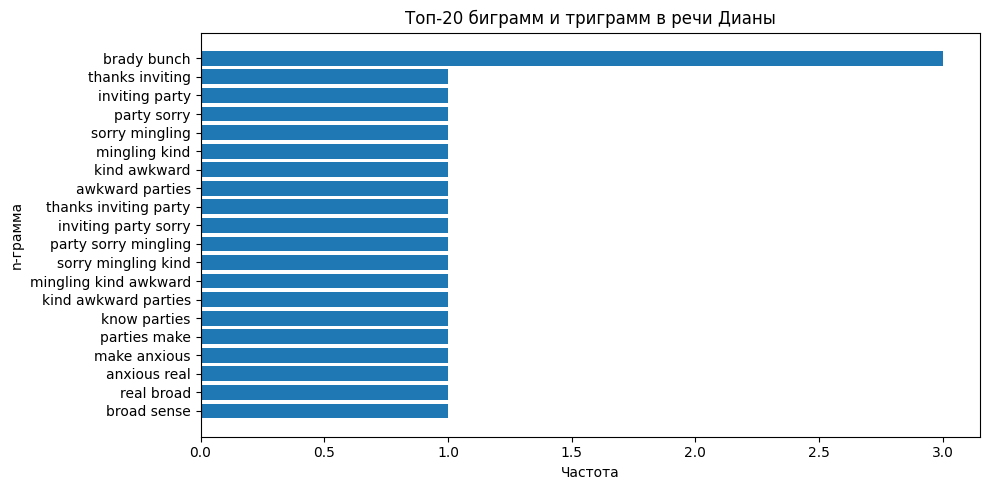

In [143]:
vectorizer = CountVectorizer(
    ngram_range=(2,3),
    stop_words="english",
    min_df=1,
    max_features=1000
)

X = vectorizer.fit_transform(cleaned_diane_phrases)
sum_words = X.sum(axis=0)

ngrams_freq = [
    (word, int(sum_words[0, idx]))
    for word, idx in vectorizer.vocabulary_.items()
]

ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)
df_ngrams = pd.DataFrame(ngrams_freq, columns=["ngram", "freq"])

plt.figure(figsize=(10,5))
plt.barh(df_ngrams.head(20)["ngram"][::-1], df_ngrams.head(20)["freq"][::-1])
plt.title("Топ-20 биграмм и триграмм в речи Дианы")
plt.xlabel("Частота")
plt.ylabel("n-грамма")
plt.tight_layout()
plt.show()

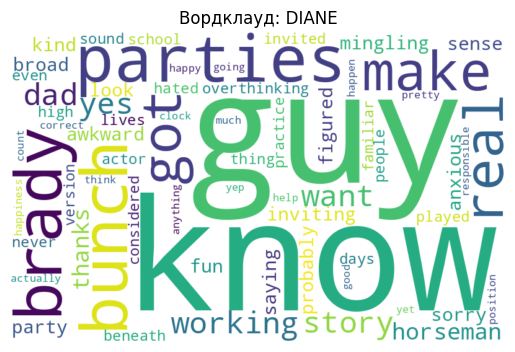

In [135]:
make_wordcloud("DIANE")

**Анализ по герою DIANE**

Частотные фразы характеризуют Диану как человека с высоким уровнем интеллекта (так, она часто называет имена выдающихся людей), а манера высказываться иронична, передает криичность и эмоциональную дистанцию (она довольно закрытый персонаж). По результатам анализа тональности преобладают позитивные реплики, однако не стоит забывать о меньшем количестве информации по герою по сравнению с ранее рассматриваемыми персонажами.

# <center style="color: #000000ff;"> **Выводы по чекпоинту 2** </center>

В результате работы над вторым чекпоинтом:

1. Был проведён поиск подходящих под задачу источников (например, в качестве вариантов рассматривали тексты классической литературы, однако с некоторыми были трудности из-за формы их написания - поэмы, а в целом по всем произведениям отличительной особенностью является отличие распределения реплик по ролям). Также был необходимо такой сценарий, в котором довольно хорошо прописаны герои, также их личность не должна сильно варьироваться от серии к серии (так, во многих долгоиграющих сериалах герои проходят существенную трансформацию, из-за чего их высказывани в начале и в конце их пути могут сильно различаться). В нашем случае мы выбрали развлекательный жанр мультфильма, где сочетаются отсутствие привязки к серии и глубокие персонажи с четко прописанными характерамми.

2. Был проведён парсинг данных и их организация в Базу Данных Chroma DB.

3. Был проведен качественый и количественный анализ в размере количества токенов, а также уникальных персонажей, встречающихся в текстах (в результате чего были выбраны возможные активные персонажи). Для этого сперва была проведен предобработка данных (удаление стоп-слов, убраны метки говорящих, а также иная лишняя информация. Были также рассмотрены опечатки и некачественные данные.

3. По некоторым персонажам сейчас не так много данных, а т.к. хотелось при генерации ответов опираться на более полценные данные, планируется добавление в БД текстов и других серий, а возможно, и сезонов. В случае аугментации данных плюсом является и умеренная продолжительность серии, а значит и длина сценария, в рамках одной серии.

4. В процессе предвраительного анализа данных применялась модель distilbert-base-uncased-finetuned-sst-2-english для оценки тонвльности и BertTopic для тематического моделирования.